In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.signal import argrelextrema
from scipy import interpolate

# Подготовительный блок

## Коррекция базовой линии

In [2]:
from scipy import sparse
from scipy.sparse.linalg import spsolve


def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) 
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) 
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

def baseline_corr(y):
    y_corr = np.zeros(len(y))
    y_corr[:429] = baseline_als_optimized(-y[:429] + 1, 10000, 0.01)
    y_corr[747:] = baseline_als_optimized(-y[747:] + 1, 10000, 0.01)
    
    y_res = -y + 1 - y_corr
    y_out = 1 - y_res
    y_out[np.argwhere(y_out > 1)] = 1

    
    return y_out
    

## Нормализация с помощью алгоритма SNV (Standard Normal Variate)

In [3]:
def SNV_Normalize(input_data):
    mean = np.mean(input_data, axis = 0)
    std = np.std(input_data, axis = 0)
    
    output_data = (input_data - mean)/std
    
    return output_data

def FullSNVNormalize(vector):
        result = []
        for spec in vector:
            result.append(SNV_Normalize(spec))
        
        return np.array(result)

## Класс Пациента

In [4]:
class Patient:
    def __init__(self, surname = '', health_class = None, old = None):
        self.surname_ = surname
        self.old_ = old
        self.health_class_ = health_class
        
        self.x_ = None
        self.backs_ = []
        self.signals_ = []
        
        self.normed_ = None
        self.SNVnormed_ = None
        
    def __str__(self):
        return f'{self.surname_} / health_class = {self.health_class_}'
    def __repr__(self):
        return self.__str__()
    
    def FullSNVNormalize(self, vector):
        result = []
        for spec in vector:
            result.append(SNV_Normalize(spec))
        
        return np.array(result)
    
    def DoNormed(self):
        self.normed_ = ((np.sum(self.signals_, axis = 0)/len(self.signals_))
                        / (np.sum(self.backs_, axis = 0)/len(self.backs_)))
        
        self.SNVnormed_ = SNV_Normalize(self.normed_)
    
    def AddSpectralData(self, x, signals, backgrounds):
        self.x_ = x
        self.signals_ = signals
        self.backs_ = backgrounds
        self.DoNormed()
    
    def AddSignal(self, signal):
        self.signals_.append(signal)
                
    def AddBackground(self, background):
        self.backs_.append(background)
        
    def GetNormedSpectrum(self):
        return self.x_, self.normed_
    
    def GetSNVNormedSpectrum(self):
        return self.x_, self.SNVnormed_
    
    def GetHealthClass(self):
        return self.health_class_
    
    def GetOverNormed(self):
        
        i = self.signals_[0]
        b = self.backs_[0]
        x = self.x_

        diff = b - (i - np.mean(i))
        
        ind = argrelextrema(diff, np.less, order = 1)[0]
        new_arr = np.concatenate( ([0], ind ) )
        new_arr = np.concatenate( (new_arr, [960] ) )
        f = interpolate.interp1d(x[new_arr], diff[new_arr])
        #print(f(x))
        res = f(x)
        res[428:747] = diff[428:747]
        
        new_i = res + (i - np.mean(i))
        
        return x, new_i / b

## Функции чтения из директории, чтения спектров и добавления пациентов в список

In [5]:
import json
def spec_read(filename):
    with open(filename) as f:
        res = f.read()
        dec = json.loads(res)
    I = np.array(dec[2]['I'])
    I[490:809] = 1
    I = I[62:]
    x = np.array(dec[2]['x'])[62:]

    return x, I
    

In [6]:
def add_patient(directory, patient_name, number_of_ill , patients_vector):
    backgrounds = []
    signals = []
    x = []
    
    patient = Patient(patient_name, health_class = number_of_ill)
    
    specs = os.listdir(directory)
    for spec in specs:
        try:
            name_list = spec.split('_')
            if(name_list[0] == 'background'):
                x_back, I_back = spec_read(f'{directory}/{spec}')
                backgrounds.append(I_back)
            if(name_list[0] == 'signal'):
                x_sig, I_sig = spec_read(f'{directory}/{spec}')
                x = x_sig
                signals.append(I_sig)
        except:
            print('Check Error in files')
       
    signals = np.array(signals)
    backgrounds = np.array(backgrounds)
    
    patient.AddSpectralData(x, signals, backgrounds)
    
    patients_vector.append(patient)

In [7]:
# Фукция вычитывающая словарь: пробегаем по папкам дат, внутри название папки(surname_(class_number)) - ключ,
# усредненный спектр - значение
def dir_reader(directory, class_number):
    dict_patients = []
    
    dates = os.listdir(directory)
    for date in dates:
        try:
            patients = os.listdir(f'{directory}/{date}')
            for patient in patients:
                patient_dir = f'{directory}/{date}/{patient}'
                add_patient(patient_dir, patient, class_number, dict_patients)
                print(f"Patient: {patient_dir}")
        except Exception as err:
            print(f"Error: {err}")
            print(f"Dir: {date}")
    return dict_patients

# Блок обработки полученных данных

## Считывание данных. Ydata - метки, Xdata - спектры 

In [8]:
healthy_vector = dir_reader('Healthy', 0)
diabet_vector = dir_reader('Sick/Diabet', 1)
astma_vector = dir_reader('Sick/Astma', 2)
pneumonia_vector = dir_reader('Sick/Pneumonia', 3)

all_vector = healthy_vector + diabet_vector + astma_vector + pneumonia_vector


Patient: Healthy/05.10.2021/Ignatova-16-Z_05_10_2021
Patient: Healthy/05.10.2021/Pokrovskiy-16-Z_05_10_2021
Patient: Healthy/05.10.2021/Titov-12-Z_05_10_2021
Patient: Healthy/05.10.2021/Varvarskay-14-Z_05_10_2021
Patient: Healthy/05.10.2021/Svintitskiy-13-Z_05_10_2021
Patient: Healthy/05.10.2021/Trubinina-14-Z_05_10_2021
Patient: Healthy/05.10.2021/Rudenko-15-Z_05_10_2021
Patient: Healthy/05.10.2021/Yozhikov-8-Z_05_10_2021
Patient: Healthy/15.10.2021/Golubev-15-Z_15_10_2021
Patient: Healthy/15.10.2021/Patenevskay-14-Z_15_10_2021
Patient: Healthy/15.10.2021/Suhorukov-12-Z_15_10_2021
Patient: Healthy/15.10.2021/Shchurin-15-Z_15_10_2021
Patient: Healthy/15.10.2021/Gorbunov-15-Z_15_10_2021
Patient: Healthy/15.10.2021/Ipatov-14-Z_15_10_2021
Patient: Healthy/15.10.2021/Lesnikova-14-Z_15_10_2021
Patient: Healthy/15.10.2021/Kuznetsova-15-Z_15_10_2021
Patient: Healthy/14.10.2021/Bliznecov-13-Z_14_10_2021
Patient: Healthy/14.10.2021/Kirilin-13-Z_14_10_2021
Patient: Healthy/14.10.2021/Mayaseev-14

Patient: Sick/Astma/25.08.2022/Krasnova
Patient: Sick/Astma/20.07.2022/Virskiy-16-AB_20_07_2022
Patient: Sick/Astma/20.07.2022/Dalgatov-13-AP_20_07_2022
Patient: Sick/Pneumonia/29.09.2022/Ananskih_1
Patient: Sick/Pneumonia/29.09.2022/Lavrin_1
Patient: Sick/Pneumonia/01.10.2022/Ananskih_3
Patient: Sick/Pneumonia/01.10.2022/Lavrin_3
Patient: Sick/Pneumonia/05.10.2022/Topilin_2
Patient: Sick/Pneumonia/05.10.2022/Mailayn_2
Patient: Sick/Pneumonia/04.10.2022/Lavrin_6
Patient: Sick/Pneumonia/04.10.2022/Topilin_1
Patient: Sick/Pneumonia/04.10.2022/Mailayn_1
Patient: Sick/Pneumonia/06.10.2022/Holekova_1
Patient: Sick/Pneumonia/06.10.2022/Topilin_3
Patient: Sick/Pneumonia/06.10.2022/Mailayn_3


In [9]:
Ydata = []
Xdata = []

for patient in all_vector:
    x, y = patient.GetNormedSpectrum()
    Xdata.append(baseline_corr(y))
    Ydata.append(patient.GetHealthClass())
    
Ydata = np.array(Ydata)
Xdata = np.array(Xdata)

print(Xdata.shape, Ydata.shape)

(171, 961) (171,)


## Кластеризация и понижение размерности методоми LDA и PCA

In [10]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pca = PCA(n_components=20)
X_r = pca.fit(Xdata).transform(Xdata)
lda = LinearDiscriminantAnalysis(n_components=3) 
X_r2 = lda.fit(Xdata, Ydata).transform(Xdata)


print('Дисперсия 95 проц при n', len(list(filter(lambda x: x < 0.95, pca.explained_variance_ratio_.cumsum()))))

Дисперсия 95 проц при n 12


In [17]:
pca = PCA(n_components=13)
X_r = pca.fit(Xdata).transform(Xdata)

lda = LinearDiscriminantAnalysis(n_components=3) 
X_r2 = lda.fit(Xdata, Ydata).transform(Xdata)

#Объяснение процентной дисперсии для каждого компонента
print('explained variance ratio for LDA : %s'
      % str(lda.explained_variance_ratio_))
print('explained variance ratio for PCA : %s'
      % str(pca.explained_variance_ratio_))
print(pca.explained_variance_ratio_.cumsum()[12])
pca_expl_var=pca.explained_variance_ratio_
lda_expl_var=lda.explained_variance_ratio_

explained variance ratio for LDA : [0.79897161 0.12109718 0.07993121]
explained variance ratio for PCA : [0.40887178 0.1741361  0.1222075  0.06518946 0.0431118  0.03473505
 0.03008999 0.02068237 0.01446825 0.0118735  0.00988409 0.00779121
 0.00709749]
0.9501385890585456


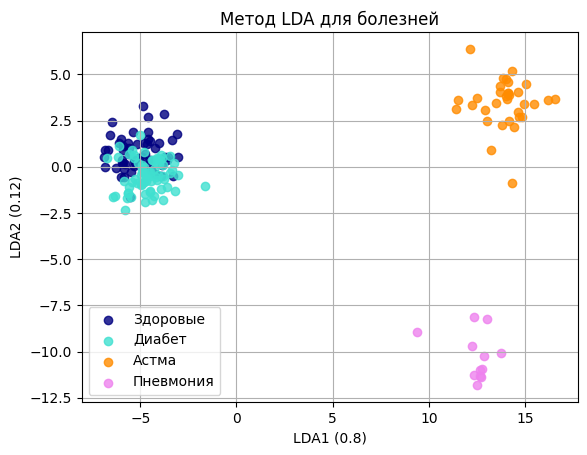

In [18]:
plt.figure()
colors = ['navy', 'turquoise', 'darkorange','violet']
lw = 3
target_names = ["Здоровые", "Диабет", "Астма", "Пневмония"]

for color, i, target_name in zip(colors, [0, 1, 2, 3], target_names):
    plt.scatter(X_r2[Ydata == i, 0], X_r2[Ydata == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Метод LDA для болезней')
plt.xlabel(f'LDA1 ({round(lda_expl_var[0], 2)})')
plt.ylabel(f'LDA2 ({round(lda_expl_var[1], 2)})')
plt.grid()
plt.savefig('lda.png')
plt.show()

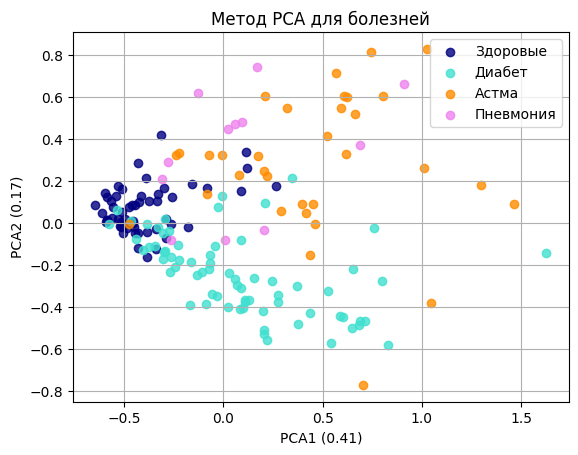

In [19]:
plt.figure()
colors = ['navy', 'turquoise', 'darkorange','violet']
lw = 2
target_names = ["Здоровые", "Диабет", "Астма", "Пневмония"]

for color, i, target_name in zip(colors, [0, 1, 2, 3], target_names):
    plt.scatter(X_r[Ydata == i, 0], X_r[Ydata == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Метод PCA для болезней')
plt.xlabel(f'PCA1 ({round(pca_expl_var[0], 2)})')
plt.ylabel(f'PCA2 ({round(pca_expl_var[1], 2)})')
plt.grid()

plt.show()

## Кластеризация и понижение размерности методом t-SNE

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(Xdata)

plt.figure()
colors = ['navy', 'turquoise', 'darkorange','violet']
lw = 2
target_names = ["Здоровые", "Диабет", "Астма", "Пневмония"]

for color, i, target_name in zip(colors, [0, 1, 2, 3], target_names):
    plt.scatter(tsne_result[Ydata == i, 0], tsne_result[Ydata == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Метод t-SNE для болезней')
plt.xlabel(f'Dimension 1')
plt.ylabel(f'Dimension 2')
plt.grid()

plt.show()

 ## Классификация методом SVM

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_r, Ydata, test_size=0.20, random_state=42)

print(Xdata.shape, X_test.shape, X_train.shape)

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 1/4, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear']} 
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 1, cv = 2)
grid.fit(X_train, y_train)
grid_predictions = grid.predict(X_test)

In [ ]:
#Confusion matrix, sensitivity and specificity
from sklearn.metrics import multilabel_confusion_matrix

cm = multilabel_confusion_matrix(y_test,grid_predictions)
#print('Confusion Matrix : \n', cm)
def conf_metric(cm, i):
    TP = cm[i, 1, 1]
    TN = cm[i, 0, 0]
    FP = cm[i, 0, 1]
    FN = cm[i, 1, 0]
    specifity = TN / (TN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    print('For i =', i)
    print('Specifity =', round(specifity, 2))
    print('Recall =', round(recall,2))
    print('precision =', round(precision, 2), '\n')
    return (specifity, precision, recall)

i = 0
while i <= 3:
    conf_metric(cm, i)
    i += 1

## Классификация методом k-NN

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_r, Ydata, test_size=0.20, random_state=42)

print(Xdata.shape, X_test.shape, X_train.shape)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {"n_neighbors": range(10, 50)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 1, cv = 5)

grid.fit(X_train, y_train)

In [ ]:

grid_predictions = grid.predict(X_test)
from sklearn.metrics import multilabel_confusion_matrix

cm = multilabel_confusion_matrix(y_test,grid_predictions)
#print('Confusion Matrix : \n', cm)
#print(confusion_matrix(y_test, y_pred))
i = 0
while i <= 3:
    conf_metric(cm, i)
    i += 1


# Случайный лес

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_r, Ydata, test_size=0.20, random_state=42, stratify=Ydata)

print(Xdata.shape, X_test.shape, X_train.shape)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 2, cv = 5)

grid.fit(X_train, y_train)

In [ ]:

grid_predictions = grid.predict(X_test)
from sklearn.metrics import multilabel_confusion_matrix


cm = multilabel_confusion_matrix(y_test,grid_predictions)
#print('Confusion Matrix : \n', cm)
#print(confusion_matrix(y_test, y_pred))
i = 0
while i <= 3:
    conf_metric(cm, i)
    i += 1

## Классификация методом Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_r, Ydata, test_size=0.20, random_state=42)

print(Xdata.shape, X_test.shape, X_train.shape)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
grid = GridSearchCV(LogisticRegression(),param_grid, refit=True, verbose = 1, cv = 5)

grid.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report

grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))


from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

cm = multilabel_confusion_matrix(y_test,grid_predictions)
print('Confusion Matrix : \n', cm)
#print(confusion_matrix(y_test, y_pred))
i = 0
while i <= 3:
    conf_metric(cm, i)
    i += 1

In [ ]:
#Confusion matrix
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,grid_predictions), annot=True,cmap="Greys", fmt=".2f")
#fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Истинные значения \n')
fx.set_ylabel('Значения классификатора \n');
fx.xaxis.set_ticklabels(['Здоровые','Диабет','Астма', 'Пневмония'])
fx.yaxis.set_ticklabels(['Здоровые','Диабет','Астма', 'Пневмония'])
plt.show()